# LangGraph 기초: 간단한 질의응답 Agent 만들기

## 학습 목표
이 노트북에서는 LangGraph의 기본 개념을 배웁니다:
- LangChain의 ChatOpenAI를 사용한 LLM 호출
- StateGraph를 이용한 워크플로우 구성
- 노드(Node)와 엣지(Edge)의 개념
- 그래프 실행 및 결과 확인

## 사전 준비
- `.env` 파일에 `OPENAI_API_KEY` 설정 필요
- Python 3.13 이상 환경

## 1. 환경 변수 로드

### 이론
`python-dotenv` 라이브러리는 `.env` 파일에서 환경 변수를 읽어옵니다.
API 키와 같은 민감한 정보를 코드에 직접 작성하지 않고 안전하게 관리할 수 있습니다.

### 코드 설명
- `load_dotenv()`: `.env` 파일의 내용을 환경 변수로 로드
- 성공하면 `True` 반환

## 2. LLM 기본 사용법

### 이론
**LLM (Large Language Model)**은 대규모 언어 모델입니다.
- OpenAI의 GPT 시리즈가 대표적
- `gpt-4o-mini`: 빠르고 저렴한 소형 모델 (이 예제에서 사용)
- `gpt-4`: 더 강력하지만 비용이 높은 모델

**LangChain의 ChatOpenAI**:
- OpenAI API를 쉽게 사용할 수 있는 래퍼 클래스
- `.invoke()`로 질문을 전달하고 답변을 받음

### 코드 설명
- `ChatOpenAI(model='gpt-4o-mini')`: LLM 인스턴스 생성
- `llm.invoke(query)`: 질문 전달 및 답변 받기
- 결과: `AIMessage` 객체 (content에 실제 답변 텍스트)

## 3. Agent 상태(State) 정의

### 이론
**State (상태)**는 Agent가 실행되는 동안 유지되는 데이터입니다.
- LangGraph는 각 노드가 상태를 읽고 수정하면서 동작
- `TypedDict`: 타입 힌트가 있는 딕셔너리 (Python 3.8+)

**메시지 누적**:
- `Annotated[list[AnyMessage], add_messages]`:
  - 메시지 리스트를 자동으로 누적 (기존 메시지에 새 메시지 추가)
  - 대화 히스토리를 유지하는 핵심 메커니즘

### 코드 설명
- `AgentState`: 우리 Agent의 상태를 정의하는 클래스
- `messages`: 사용자 메시지와 AI 답변을 담는 리스트
- `add_messages`: LangGraph가 제공하는 메시지 누적 함수

## 4. StateGraph 생성

### 이론
**StateGraph**는 LangGraph의 핵심 클래스입니다.
- 노드(Node)와 엣지(Edge)로 구성된 워크플로우 그래프
- 각 노드는 상태를 읽고 수정하는 함수
- 엣지는 노드 간의 연결(실행 순서)

### 코드 설명
- `StateGraph(AgentState)`: AgentState를 사용하는 그래프 생성
- `graph_builder`: 그래프를 구성할 빌더 객체

## 5. 노드 함수 정의

### 이론
**노드(Node)**는 그래프에서 실행되는 작업 단위입니다.
- 입력: 현재 `AgentState`
- 출력: 업데이트할 상태 (딕셔너리)
- 반환된 딕셔너리는 기존 상태와 병합됨

**generate 노드의 역할**:
1. 상태에서 마지막 메시지 가져오기
2. LLM으로 답변 생성
3. 생성된 답변을 상태에 추가

### 코드 설명
- `state['messages']`: 현재 대화 히스토리
- `messages[-1].content`: 가장 최근 메시지 내용
- `llm.invoke()`: LLM에 메시지 전달
- `return {'messages': [ai_message]}`: 새 메시지를 상태에 추가

## 6. 그래프에 노드 추가

### 이론
**노드 추가**는 그래프에 실행 가능한 작업을 등록하는 과정입니다.
- `add_node(이름, 함수)`: 노드를 그래프에 추가
- 노드 이름은 엣지 연결 시 사용됩니다.

### 코드 설명
- `'generate'`: 노드의 이름 (문자열)
- `generate`: 앞서 정의한 노드 함수
- 이제 이 노드는 그래프 내에서 'generate'라는 이름으로 사용 가능

## 7. 엣지(Edge) 연결

### 이론
**엣지(Edge)**는 노드 간의 연결을 정의합니다.
- `START`: 그래프의 시작점 (특수 노드)
- `END`: 그래프의 종료점 (특수 노드)
- 엣지는 실행 흐름을 결정

**실행 흐름**:
```
START → generate → END
```

### 코드 설명
- `add_edge(START, 'generate')`: 시작하자마자 generate 노드 실행
- `add_edge('generate', END)`: generate 완료 후 종료

## 8. 그래프 컴파일

### 이론
**컴파일(Compile)**은 그래프를 실행 가능한 형태로 변환합니다.
- 노드와 엣지의 연결 검증
- 실행 가능한 runnable 객체 생성

### 코드 설명
- `compile()`: 그래프를 컴파일하여 실행 가능한 객체 반환
- 이제 `graph.invoke()`로 실행 가능

## 9. 그래프 시각화

### 코드 설명
- `get_graph().draw_mermaid_png()`: 그래프를 Mermaid 다이어그램으로 시각화
- 노드 간의 연결 관계를 그림으로 확인 가능

## 10. 그래프 실행 테스트

### 이론
**그래프 실행 방법**:
1. 초기 상태 생성 (사용자 메시지 포함)
2. `graph.invoke(초기_상태)` 호출
3. 결과에서 최종 상태 확인

### 코드 설명
- `HumanMessage(query)`: 사용자 메시지 객체 생성
- `initial_state`: 초기 대화 상태
- `graph.invoke()`: 그래프 실행
- 결과의 `messages`에 사용자 메시지 + AI 답변 포함

In [ ]:
# 패키지
# %pip install -q python-dotenv langchain-openai langgraph langchain-community


In [13]:
from dotenv import load_dotenv

load_dotenv()

True

In [14]:
# 간단한 질문 테스트
from langchain_openai import ChatOpenAI

query = 'llm과 같이 주식 투자하는거 어떨까요?'
#
llm = ChatOpenAI(model='gpt-4o-mini') # 작은 모델
llm.invoke(query)


AIMessage(content='LLM(대규모 언어 모델)을 사용하여 주식 투자에 접근하는 것은 흥미로운 아이디어입니다. LLM은 광범위한 데이터와 패턴을 분석하고 정보를 제공하는 데 유용할 수 있습니다. 하지만 몇 가지 고려사항이 있습니다.\n\n1. **정보 분석**: LLM은 과거 데이터와 뉴스, 금융 보고서 등을 기반으로 정보를 분석할 수 있습니다. 이를 통해 특정 회사나 산업에 대한 통찰력을 제공받을 수 있습니다.\n\n2. **리스크 관리**: 주식 시장은 변동성이 크고 예측하기 어려운 요소가 많습니다. LLM의 분석 결과를 맹신하기보다는 여러 가지 정보를 종합하여 판단하는 것이 중요합니다.\n\n3. **최신 정보 반영**: LLM은 훈련된 데이터에 기반하므로 최신 시장 동향이나 사건을 반영하기 어려운 경우가 많습니다. 따라서 LLM의 정보를 사용할 때는 항상 현재의 시장 상황과 최신 뉴스를 확인하는 것이 좋습니다.\n\n4. **심리적 요소**: 주식 투자는 종종 투자자의 감정과 심리가 크게 작용합니다. LLM은 데이터 기반으로 분석하지만 인간의 감정적 요소를 완전히 이해하거나 반영하지 못할 수 있습니다.\n\n5. **결과 검증**: LLM을 통해 얻은 투자 전략이나 조언은 실제로 검증해보고, 성과를 분석하는 과정이 필요합니다.\n\n결론적으로, LLM과 함께 주식 투자하는 것은 유익할 수 있지만, 다른 여러 요소와 정보를 함께 고려하여 신중하게 접근하는 것이 중요합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 345, 'prompt_tokens': 20, 'total_tokens': 365, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction

In [15]:
# State 생성
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [16]:
from langgraph.graph import StateGraph
graph_builder = StateGraph(AgentState)

In [17]:
def generate(state: AgentState) -> AgentState:
    """
    Generates a new state for the agent based on the given state.

    This function takes an existing state of an agent and processes it
    to generate a new state. The transformation from the input state
    to the output state adheres to specific rules or logic defined in
    the function.

    :param state: The current state of the agent.
    :type state: AgentState
    :return: A new state derived from the input state.
    :rtype: AgentState
    """
    messages = state['messages']
    ai_message = llm.invoke(messages[-1].content)
    return {'messages': [ai_message]}

In [18]:
graph_builder.add_node('generate', generate)


In [19]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)


## 실습 문제

아래 3개의 문제를 순서대로 풀어보세요. LangGraph 기본 사용법을 익히는 데 도움이 됩니다.

In [8]:
graph = graph_builder.compile()

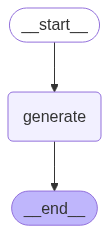

In [20]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
from langchain_core.messages import HumanMessage

query="현재 2025년 7월에 삼성전자 주식에 투자하는 건 어떨까?"
initial_state={'messages': [HumanMessage(query)]}
graph.invoke(initial_state)

{'messages': [HumanMessage(content='현재 2025년 7월에 삼성전자 주식에 투자하는 건 어떨까?', additional_kwargs={}, response_metadata={}, id='0dc55645-247d-40c6-b114-332446c6e0fc'),
  AIMessage(content='2025년 7월에 삼성전자 주식에 투자하는 것에 대한 결정을 하려면 여러 가지 요소를 고려해야 합니다. 기본적으로 다음과 같은 사항들을 검토하는 것이 좋습니다:\n\n1. **재무 성과**: 삼성전자의 최근 재무 성과와 미래 성장 가능성을 분석해야 합니다. 매출, 이익, 부채 비율 및 주가 수익 비율(PER) 등을 고려해보세요.\n\n2. **산업 동향**: 반도체, 전자제품, 모바일 기기 등 삼성전자가 주요 사업을 하고 있는 분야의 시장 동향 및 경쟁 상황을 분석할 필요가 있습니다.\n\n3. **글로벌 경제 상황**: 2025년의 글로벌 경제 전망과 지정학적 리스크, 통화 정책 등을 고려해야 합니다. 이러한 요소들은 주가에 큰 영향을 미칠 수 있습니다.\n\n4. **기술 혁신**: 삼성전자는 기술 혁신에 적극적으로 투자하고 있으므로, 새로운 제품이나 기술 개발 계획이 향후 주가에 어떻게 영향을 미칠지 분석해야 합니다.\n\n5. **전문가 의견 및 분석**: 금융 전문가나 애널리스트의 의견 및 연구 보고서를 참고하는 것도 좋은 방법입니다. 그들의 전망이 여러분의 투자 결정에 어떤 영향을 미칠 수 있는지를 고려하세요.\n\n6. **개인 투자 목표**: 자신의 투자 목표, 기간, 리스크 수용 능력 등을 명확히 하고 이에 맞는 결정을 내리는 것이 중요합니다.\n\n미래의 주식 투자에 대해 예측하는 것은 본질적으로 불확실성을 동반하므로, 신중한 접근이 필요합니다. 전문가와 상담하거나 전문 자료를 참고하면서 결정을 내리는 것이 좋습니다.', additional_kwargs={'refusal': None}, response_metadata={'t

In [ ]:
# TODO: LLM에게 질문하기
my_question = ___  # "주식 투자의 장점은 무엇인가요?" 입력
response = llm.invoke(___)  # 빈칸을 채우세요

print(f"질문: {my_question}")
print(f"답변: {response.content[:150]}...")  # 처음 150자만 출력

# 기대 결과: LLM이 생성한 주식 투자의 장점에 대한 설명

In [ ]:
# TODO: 노드 함수 완성하기
def my_generate_node(state: AgentState) -> AgentState:
    """사용자 메시지를 받아서 LLM으로 답변 생성"""
    messages = state[___]  # 빈칸을 채우세요 ('messages')
    last_message = messages[-1]
    
    # LLM으로 답변 생성
    ai_response = llm.invoke(___)  # 빈칸을 채우세요 (last_message.content)
    
    return {___: [ai_response]}  # 빈칸을 채우세요 ('messages')

# 테스트
from langchain_core.messages import HumanMessage
test_state = {'messages': [HumanMessage(content="안녕하세요")]}
result = my_generate_node(test_state)
print(f"생성된 답변: {result['messages'][0].content[:100]}...")

# 기대 결과: LLM이 생성한 인사 답변

In [ ]:
# TODO: 나만의 질문으로 그래프 실행
from langchain_core.messages import HumanMessage

my_own_question = ___  # 여기에 질문을 작성하세요
initial_state = {___: [HumanMessage(my_own_question)]}  # 빈칸을 채우세요 ('messages')

print(f"질문: {my_own_question}")
print("="*70)

# 그래프 실행
result = graph.invoke(___)  # 빈칸을 채우세요 (initial_state)

# 결과 출력
final_answer = result['messages'][-1].content
print(f"답변:\n{final_answer}")

# 기대 결과: 질문에 대한 LLM의 답변

In [ ]:
# 정답 예시 (주석 해제하여 확인)

# # 문제 1
# my_question = "주식 투자의 장점은 무엇인가요?"
# response = llm.invoke(my_question)

# # 문제 2
# def my_generate_node(state: AgentState) -> AgentState:
#     messages = state['messages']
#     last_message = messages[-1]
#     ai_response = llm.invoke(last_message.content)
#     return {'messages': [ai_response]}

# # 문제 3
# my_own_question = "주식 투자 초보자를 위한 조언은?"
# initial_state = {'messages': [HumanMessage(my_own_question)]}
# result = graph.invoke(initial_state)

---

## 정답 확인

모든 문제를 풀었다면, 아래 셀의 주석을 해제하여 정답을 확인할 수 있습니다.

### 문제 3: 나만의 간단한 그래프 실행하기

**목표**: 위에서 배운 내용을 활용하여 나만의 질문으로 그래프를 실행해보세요.

**힌트**:
- `HumanMessage`로 질문 메시지 생성
- `graph.invoke()`로 그래프 실행
- 결과에서 마지막 메시지가 AI의 답변입니다.

**추천 질문 예시**:
- "주식 투자 초보자를 위한 조언은?"
- "ETF란 무엇인가요?"
- "배당주 투자의 장단점은?"

### 문제 2: StateGraph 노드 함수 만들기

**목표**: 사용자 메시지를 받아서 LLM으로 답변을 생성하는 노드 함수를 작성하세요.

**힌트**: 
- 함수는 `AgentState`를 입력받고 반환합니다.
- `state['messages']`에서 메시지를 가져옵니다.
- LLM으로 답변을 생성하고 `{'messages': [답변]}`을 반환합니다.

### 문제 1: ChatOpenAI로 간단한 질문하기

**목표**: LLM에게 "주식 투자의 장점은 무엇인가요?"라고 질문하고 답변을 받으세요.

**힌트**: `llm.invoke()` 메서드를 사용하세요.